In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import zipfile
import os
import random

# Google Drive'ı mount etme
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Zip dosyasını açma
zip_path = '/content/drive/My Drive/Datasets/EMG Physical Action Data Set.zip'
extract_path = '/content/emg_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
# Veriyi yükleyelim ve etiketlerin doğru formatta olup olmadığını kontrol etme
def load_emg_data_kaggle(path):
    emg_data = []
    labels = []
    for root, dirs, files in os.walk(path):
        for filename in files:
            if filename.endswith('.csv'):
                data = pd.read_csv(os.path.join(root, filename))
                emg_signals = data.iloc[:, :-1].values
                gesture_id = data.iloc[:, -1].values

                # Etiketlerin integer olup olmadığını kontrol edelim ve değilse dönüştürme
                if not np.issubdtype(gesture_id.dtype, np.integer):
                    try:
                        gesture_id = gesture_id.astype(int)
                    except ValueError:
                        print(f"Error converting labels in file: {filename}")
                        continue

                emg_data.append(emg_signals)
                labels.append(gesture_id)

    if emg_data and labels:  # Veri var mı kontrol etme
        return np.concatenate(emg_data), np.concatenate(labels)
    else:
        return np.array([]), np.array([])

path = extract_path
emg_data, labels = load_emg_data_kaggle(path)

# Etiketlerin benzersiz değerlerini ve sınıf sayısını belirleme
unique_labels = np.unique(labels)
n_classes = len(unique_labels)

print(f"Etiketlerin benzersiz değerleri: {unique_labels}")
print(f"Toplam sınıf sayısı: {n_classes}")


Etiketlerin benzersiz değerleri: [0 1 2 3 4 5 6 7 8 9]
Toplam sınıf sayısı: 10


In [ ]:
if emg_data.size != 0 and labels.size != 0:
    # Verileri ölçekleme
    scaler = StandardScaler()
    emg_data_scaled = scaler.fit_transform(emg_data)

    # Eğitim ve test setlerine bölme
    X_train, X_test, y_train, y_test = train_test_split(emg_data_scaled, labels, test_size=0.2, random_state=42)

    # Verileri LSTM modeline uygun hale getirme
    n_timesteps = 100  # Zaman adımı
    n_features = emg_data.shape[1]  # Özellik sayısı

    def create_sequences(data, labels, n_timesteps):
        sequences = []
        for i in range(len(data) - n_timesteps):
            sequence = data[i:i+n_timesteps]
            label = labels[i+n_timesteps-1]
            sequences.append((sequence, label))
        X, y = zip(*sequences)
        return np.array(X), np.array(y)

    X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_timesteps)

    # Etiketleri one-hot encoding ile dönüştürme
    y_train_seq = tf.keras.utils.to_categorical(y_train_seq, num_classes=n_classes)
    y_test_seq = tf.keras.utils.to_categorical(y_test_seq, num_classes=n_classes)


In [ ]:
# LSTM modelini oluşturma
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
1928/1928 [==============================] - 20s 9ms/step - loss: 2.1275 - accuracy: 0.1879 - val_loss: 2.0308 - val_accuracy: 0.2210
Epoch 2/100
1928/1928 [==============================] - 16s 8ms/step - loss: 2.0080 - accuracy: 0.2299 - val_loss: 1.9963 - val_accuracy: 0.2366
Epoch 3/100
1928/1928 [==============================] - 17s 9ms/step - loss: 1.9713 - accuracy: 0.2562 - val_loss: 1.9704 - val_accuracy: 0.2555
Epoch 4/100
1928/1928 [==============================] - 17s 9ms/step - loss: 1.9314 - accuracy: 0.2815 - val_loss: 1.9330 - val_accuracy: 0.2790
Epoch 5/100
1928/1928 [==============================] - 16s 9ms/step - loss: 1.8909 - accuracy: 0.2983 - val_loss: 1.9047 - val_accuracy: 0.2870
Epoch 6/100
1928/1928 [==============================] - 16s 8ms/step - loss: 1.8542 - accuracy: 0.3124 - val_loss: 1.8812 - val_accuracy: 0.2940
Epoch 7/100
1928/1928 [==============================] - 16s 9ms/step - loss: 1.8229 - accuracy: 0.3230 - val_loss: 1.8665 -

In [ ]:
# Model parametrelerini gösterme
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               43600     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 44610 (174.26 KB)
Trainable params: 44610 (174.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1203/1203 [==============================] - 5s 4ms/step


<Figure size 1600x1200 with 0 Axes>

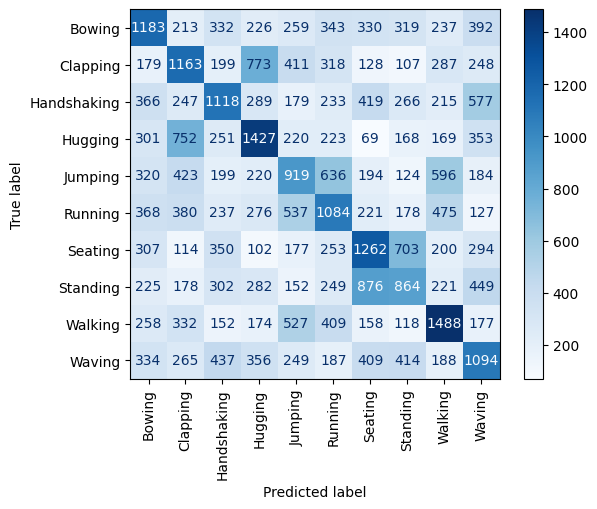

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Karışıklık matrisi oluşturma ve görselleştirme
y_pred = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_seq, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[
    'Bowing', 'Clapping', 'Handshaking', 'Hugging', 'Jumping', 'Running', 'Seating',
    'Standing', 'Walking', 'Waving'
])

# Daha büyük bir figür boyutu ayarlama
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()


1/1 [==============================] - 0s 19ms/step
Gerçek Sınıf: 3 (Hugging)
Tahmin Edilen Sınıf: 7 (Standing)


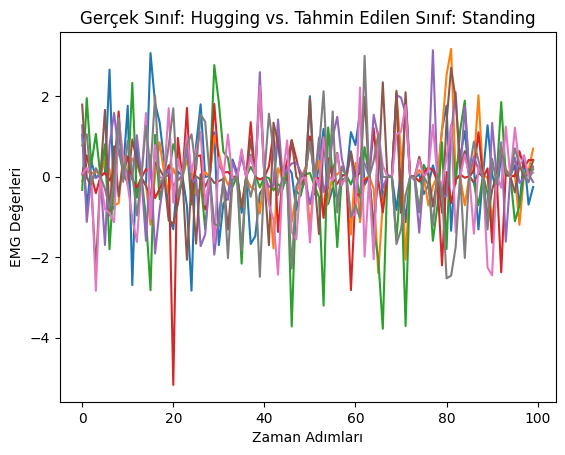

In [ ]:
# Rastgele bir örnek verinin tahmini ve görselleştirilmesi
random_index = random.randint(0, X_test_seq.shape[0] - 1)
random_sample = X_test_seq[random_index]
random_sample_reshaped = random_sample.reshape(1, n_timesteps, n_features)

predicted_class = np.argmax(model.predict(random_sample_reshaped), axis=1)[0]
true_class = np.argmax(y_test_seq[random_index])

print(f"Gerçek Sınıf: {true_class} ({disp.display_labels[true_class]})")
print(f"Tahmin Edilen Sınıf: {predicted_class} ({disp.display_labels[predicted_class]})")

# Rastgele örnek verinin görselleştirilmesi
plt.plot(random_sample)
plt.title(f"Gerçek Sınıf: {disp.display_labels[true_class]} vs. Tahmin Edilen Sınıf: {disp.display_labels[predicted_class]}")
plt.xlabel("Zaman Adımları")
plt.ylabel("EMG Değerleri")
plt.show()


In [ ]:
# Kullanılan veri sayısını gösterme
print(f"Eğitim için kullanılan örnek sayısı: {X_train_seq.shape[0]}")
print(f"Test için kullanılan örnek sayısı: {X_test_seq.shape[0]}")


Eğitim için kullanılan örnek sayısı: 154189
Test için kullanılan örnek sayısı: 38473


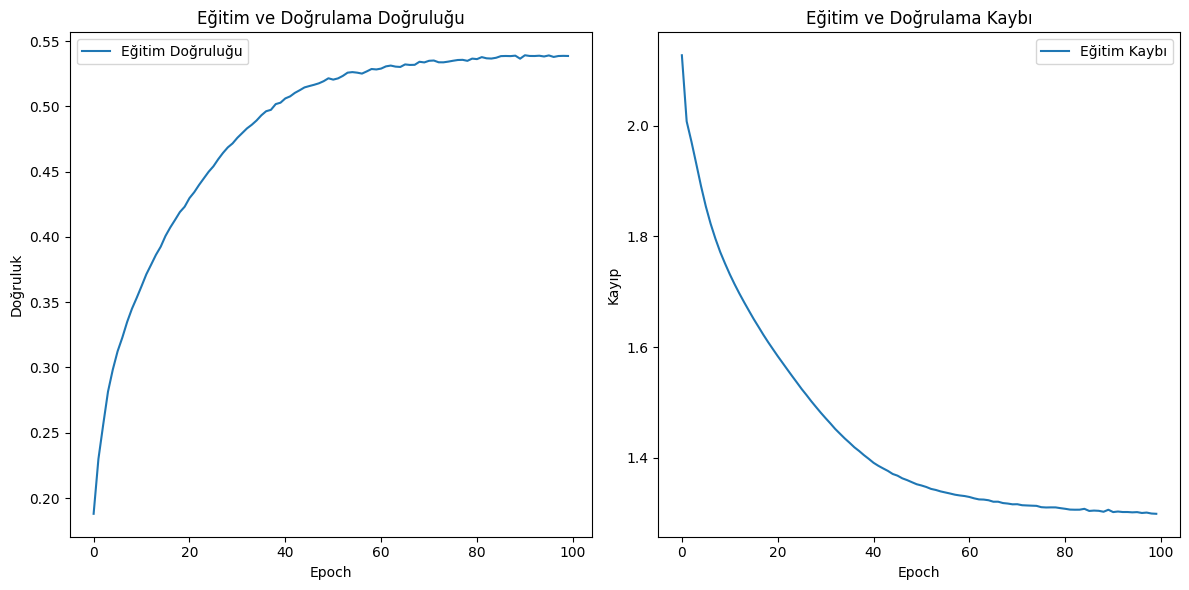

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')

plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp değerlerini görselleştirme
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')

plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()